In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from koopman_autoencoder import *

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')

## Load dataset

In [5]:
def build_dataset(data_dict):
    time = []
    data = []
    I_p = []
    for index, contents in data_dict.items():
        time.append(contents['time'])
        data.append(contents['data'])
        I_p.append(contents['I_p'])
    
    data = np.array(data)
    x_data = data[:-1,:]
    y_data = data[1:,:]
    dt_data = (time[1] - time[0]) * np.ones((data.shape[0] -1 , 1))
    # I_p = np.reshape(np.array(I_p)[:-1], (-1,1))
    u_data = np.concatenate((dt_data, np.reshape(np.array(I_p)[:-1], (-1,1)), np.reshape(np.array(I_p)[1:], (-1,1))), axis = 1)
    return x_data, y_data, u_data

In [6]:
import numpy as np
import os

x_dataset = []
y_dataset = []
u_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
        
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u_data = build_dataset(data_dict)
        x_dataset.append(x_data)
        y_dataset.append(y_data)
        u_dataset.append(u_data)
    else:
        print(f"File not found: {data_file_path}")


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [7]:
x_data = np.concatenate(x_dataset, axis = 0)
y_data = np.concatenate(y_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)
x_data.shape

(7221, 6957)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


# Scaling the datasets
scaler_x = StandardScaler().fit(x_data)
scaler_u = StandardScaler().fit(u_data)

x_data_scaled = scaler_x.transform(x_data)
y_data_scaled = scaler_x.transform(y_data)
u_data_scaled = scaler_u.transform(u_data)

shuffled_indices = np.arange(len(x_data))
np.random.shuffle(shuffled_indices)

x_data_scaled = x_data_scaled[shuffled_indices]
y_data_scaled = y_data_scaled[shuffled_indices]
u_data_scaled = u_data_scaled[shuffled_indices]

x_train, x_test = train_test_split(x_data_scaled, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y_data_scaled, test_size=0.2, random_state=42)
u_train, u_test = train_test_split(u_data_scaled, test_size=0.2, random_state=42)


In [34]:
n_input = x_data.shape[1]
layer_sizes_dic = [64, 128, 128, 512]
layer_sizes_k = [64, 128, 64]

n_psi_train = 256
u_dim = 3

model_psi, model_koopman, model_inv_psi, model_predict, model_auto \
= Build_model(n_input, layer_sizes_dic, layer_sizes_k, n_psi_train, u_dim, para = True)

In [38]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR


x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
u_test = torch.tensor(u_test, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(x_train, y_train, u_train)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the optimizer
optimizer = Adam(list(model_koopman.parameters()) + 
                       list(model_inv_psi.parameters()), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=200, gamma=0.1)

mse_loss = nn.MSELoss()

lambda_1 = 1.0
lambda_2 = 1.0
lambda_3 = 1.0


/tmp/ipykernel_1768598/1777738811.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_1768598/1777738811.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_1768598/1777738811.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_train = torch.tensor(u_train, dtype=torch.float32)
/tmp/ipykernel_1768598/1777738811.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.cl

In [39]:
# Initialize a list to store the loss values
train_losses = []
val_losses = []

# Training process

for step in range(600):
    for x_batch, y_batch, u_batch in data_loader:
        # Forward propagation
        optimizer.zero_grad()
        koopman_pred = model_koopman(x_batch, y_batch, u_batch)
        auto_pred = model_auto(x_batch)
        predict_pred = model_predict(x_batch, u_batch)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_batch) \
               + lambda_3 * mse_loss(predict_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
    
    # Training Loss
    koopman_pred = model_koopman(x_train, y_train, u_train)
    auto_pred = model_auto(x_train)
    predict_pred = model_predict(x_train, u_train)

    loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
               + lambda_2 * mse_loss(auto_pred, x_train) \
               + lambda_3 * mse_loss(predict_pred, y_train)        
    train_losses.append(loss.item())
        
    print(f'Epoch: {step}, Loss: {loss.item()}')


    # Test the model
    with torch.no_grad():
        koopman_pred = model_koopman(x_test, y_test, u_test)
        auto_pred = model_auto(x_test)
        predict_pred = model_predict(x_test, u_test)

        loss = lambda_1 * mse_loss(koopman_pred, torch.zeros_like(koopman_pred)) \
           + lambda_2 * mse_loss(auto_pred, x_test) \
           + lambda_3 * mse_loss(predict_pred, y_test)
        val_losses.append(loss.item())

    
    print(f'Epoch: {step}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.8399149179458618
Epoch: 0, Loss: 0.8018614649772644
Epoch: 1, Loss: 0.652751088142395
Epoch: 1, Loss: 0.6216229200363159
Epoch: 2, Loss: 0.3461642265319824
Epoch: 2, Loss: 0.3345509171485901
Epoch: 3, Loss: 0.18753209710121155
Epoch: 3, Loss: 0.1812562197446823
Epoch: 4, Loss: 0.14502131938934326
Epoch: 4, Loss: 0.14174258708953857
Epoch: 5, Loss: 0.11604778468608856
Epoch: 5, Loss: 0.11242848634719849
Epoch: 6, Loss: 0.1037110984325409
Epoch: 6, Loss: 0.10050572454929352
Epoch: 7, Loss: 0.093661829829216
Epoch: 7, Loss: 0.09095434099435806
Epoch: 8, Loss: 0.0891636461019516
Epoch: 8, Loss: 0.08653242886066437
Epoch: 9, Loss: 0.08047623187303543
Epoch: 9, Loss: 0.07853633165359497
Epoch: 10, Loss: 0.07548843324184418
Epoch: 10, Loss: 0.07358880341053009
Epoch: 11, Loss: 0.06048021465539932
Epoch: 11, Loss: 0.05894306302070618
Epoch: 12, Loss: 0.04424811899662018
Epoch: 12, Loss: 0.043292902410030365
Epoch: 13, Loss: 0.03609822690486908
Epoch: 13, Loss: 0.0352511703968

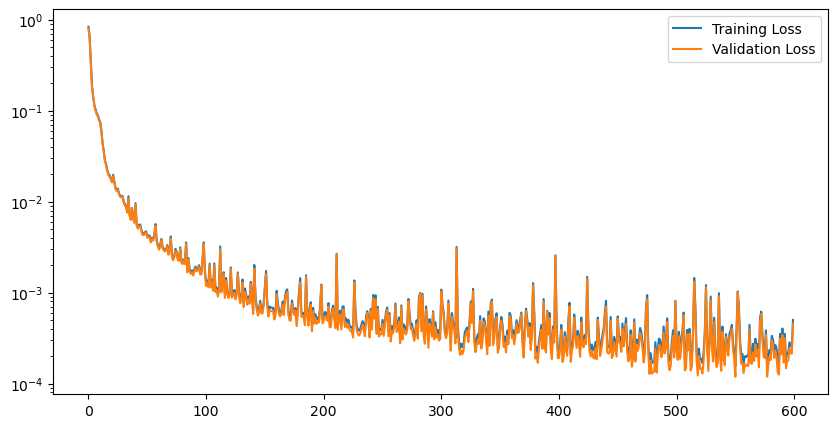

In [40]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [41]:
# data_file_path = '../data/data_dict_' + str(40) + '.npy'
        
# # Check if the file exists before trying to load it
# if os.path.exists(data_file_path):
#     data_dict = np.load(data_file_path, allow_pickle=True).item()
#     x_traj_test1, y_traj_test1, u_traj_test1 = build_dataset(data_dict)
# else:
#     print(f"File not found: {data_file_path}")


In [42]:
x_dataset_scaled = [scaler_x.transform(x) for x in x_dataset]
u_dataset_scaled = [scaler_u.transform(u) for u in u_dataset]

In [43]:
# x_traj_test_scaled = scaler_x.transform(np.array(x_traj_test1))
# u_traj_test_scaled = scaler_u.transform(np.array(u_traj_test1))

In [44]:
para_k = model_koopman.Para_k

In [45]:
import torch

def koopman_predict(initial_data, u_data, steps, model_psi, model_inv_psi, para_k):
    data_traj = []
    
    initial_data_tensor = torch.tensor(initial_data, dtype=torch.float32).reshape((1, -1))
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    
    data_traj.append(initial_data_tensor)
    psi_x = model_psi(initial_data_tensor)
    psi_x_expanded = psi_x.unsqueeze(1)
    
    for step in range(steps):
        u = u_data_tensor[step,:].reshape((1, -1))
        psi_y_expanded = torch.bmm(psi_x_expanded, para_k(u))
        psi_y = psi_y_expanded.squeeze(1)
        data_traj.append(model_inv_psi(psi_y).detach().numpy())
        psi_x_expanded = psi_y_expanded

    return data_traj


In [46]:
steps = 50

In [47]:
import numpy as np
import torch

pred_data_traj = []
for x, u in zip(x_dataset_scaled, u_dataset_scaled):
    x_pred_scaled_traj = koopman_predict(x[0, :], u, steps, model_psi, model_inv_psi, para_k)
    
    x_pred_scaled = np.concatenate(x_pred_scaled_traj, axis=0)
    
    x_pred = scaler_x.inverse_transform(x_pred_scaled)
    pred_data_traj.append(x_pred)

In [48]:
errors = [pred_data_traj[i] - x_dataset[i][:(steps+1), :] for i in range(len(pred_data_traj))]

# Calculate the norm of the error for each element
error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

# Calculate the norm of the original data for each element
data_norms = [np.linalg.norm(x_dataset[i][:(steps+1), :]) for i in range(len(x_dataset))]


# Calculate the ratio of the error norm to the data norm for each element
relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))]

# Calculate the mean and standard deviation of the relative errors for each element
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)

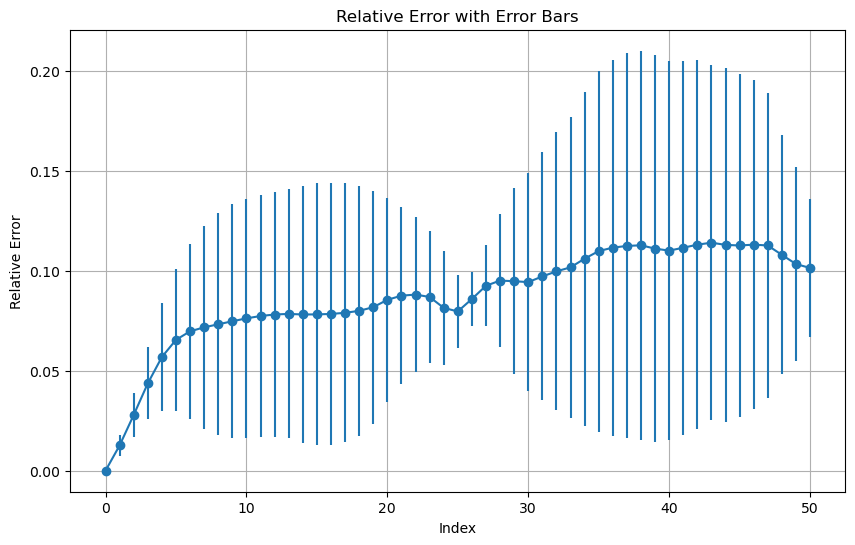

In [49]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps+1), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [50]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [51]:
np.mean(domain_relative_error)

0.7332888764261277

In [52]:
np.std(domain_relative_error)

0.2858037695278819

In [53]:
mean_relative_errors

array([1.22237729e-10, 1.26287695e-02, 2.78674304e-02, 4.36649512e-02,
       5.68481265e-02, 6.54488305e-02, 6.97149111e-02, 7.17088244e-02,
       7.32303737e-02, 7.47418664e-02, 7.61981376e-02, 7.73626012e-02,
       7.81257493e-02, 7.84295490e-02, 7.81335949e-02, 7.81768524e-02,
       7.84138958e-02, 7.89686640e-02, 7.99567907e-02, 8.17831437e-02,
       8.54624608e-02, 8.75379781e-02, 8.80891284e-02, 8.68929974e-02,
       8.14489916e-02, 7.96496839e-02, 8.58772206e-02, 9.24996328e-02,
       9.50882508e-02, 9.47751003e-02, 9.43201506e-02, 9.71670552e-02,
       9.96905459e-02, 1.01715040e-01, 1.06034785e-01, 1.09841923e-01,
       1.11558469e-01, 1.12415526e-01, 1.12745050e-01, 1.11072224e-01,
       1.10067975e-01, 1.11519987e-01, 1.13038956e-01, 1.14045479e-01,
       1.12949122e-01, 1.12638611e-01, 1.13063536e-01, 1.12638779e-01,
       1.07960159e-01, 1.03356950e-01, 1.01409387e-01])

In [54]:
mean_relative_errors[1]

0.012628769453443947

In [55]:
steps = 1
diff_abs = []
for i in range(x_data.shape[0]):
    x = torch.tensor(x_data_scaled[i:i+1, :], dtype=torch.float32)
    y = y_data[i:i+1, :]
    u = torch.tensor(u_data_scaled[i:i+1, :], dtype=torch.float32)
    x_pred_traj = model_predict(x, u)
    diff_abs.append(np.abs(y.flatten()-scaler_x.inverse_transform(x_pred_traj.detach().numpy())))

In [56]:
diff_abs = np.concatenate(diff_abs)
diff_abs.shape

(7221, 6957)

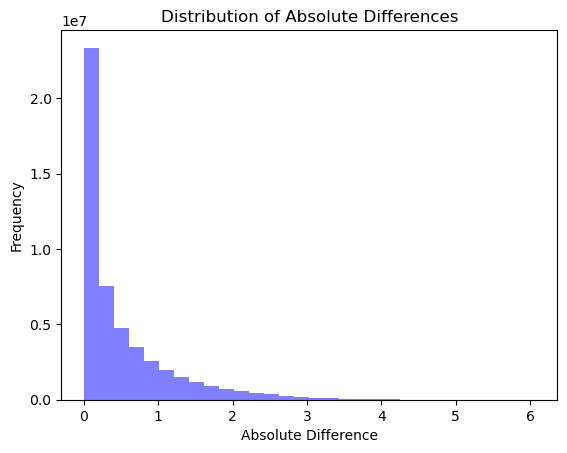

In [60]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(diff_abs.flatten(), bins=30, alpha=0.5, color='blue')
plt.title('Distribution of Absolute Differences')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.show()


In [59]:
np.max(diff_abs)

6.064928257059543